In [1]:
import pandas as pd
import numpy as np
import csv
from datetime import datetime, timedelta
from sklearn.datasets import make_regression
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
import matplotlib
import itertools
from pylab import rcParams
import pickle
import warnings
warnings.filterwarnings("ignore")

/Users/vaishrohan/anaconda2/lib/python2.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
mapping = {}
for i in range(1,7):
    file_path = 'low_freq/house_' + str(i) + '/labels.dat'
    mapping[i] = {}
    with open(file_path) as file:
        for line in file:
            mapping[i][int(line.split(' ')[0].strip())] = line.split(' ')[1].strip() + '_' + line.split(' ')[0].strip()
print(mapping[1])

{1: 'mains_1', 2: 'mains_2', 3: 'oven_3', 4: 'oven_4', 5: 'refrigerator_5', 6: 'dishwaser_6', 7: 'kitchen_outlets_7', 8: 'kitchen_outlets_8', 9: 'lighting_9', 10: 'washer_dryer_10', 11: 'microwave_11', 12: 'bathroom_gfi_12', 13: 'electric_heat_13', 14: 'stove_14', 15: 'kitchen_outlets_15', 16: 'kitchen_outlets_16', 17: 'lighting_17', 18: 'lighting_18', 19: 'washer_dryer_19', 20: 'washer_dryer_20'}


In [3]:
df = {}
for i in range(1,7):
    file_path = 'low_freq/house_' + str(i) + '/channel_' + str(i) + '.dat'
    df[i] = pd.read_csv(file_path , sep = ' ', names = ['TimeStamp', mapping[i][1]], dtype = {'TimeStamp': 'int64', mapping[i][1]:'float64'})
    for j in range(2, len(mapping[i])+1):
        curr_file_path =  'low_freq/house_' + str(i) + '/channel_' + str(j) + '.dat'
        curr = pd.read_csv(curr_file_path , sep = ' ', names = ['TimeStamp', mapping[i][j]], dtype = {'TimeStamp': 'int64', mapping[i][j]:'float64'})
        df[i] = pd.merge(df[i], curr, how='inner', on='TimeStamp')
    df[i]['TimeStamp'] = df[i]['TimeStamp'].astype("datetime64[s]")
        

In [4]:
for i in range(1,7):
    for j, row in df[i].iterrows():
        df[i].at[j,'Year'] = row[0].year
        df[i].at[j,'Month'] = row[0].month
        df[i].at[j,'Day'] = row[0].day
        df[i].at[j,'Hour'] = row[0].hour
        df[i].at[j,'Minute'] = row[0].minute
        df[i].at[j,'Seconds'] = row[0].second
        if row[0].weekday() in [5,6] :
            df[i].at[j, 'Holiday'] = 1
        else:
            df[i].at[j, 'Holiday'] = 0
        if row[0].hour in [0,1,2,3,4,5,6,7,20,21,22,23]:
            df[i].at[j, 'Peak Hour'] = 1
        else:
            df[i].at[j, 'Peak Hour'] = 0
        


In [29]:
mapping[1]

{1: 'mains_1',
 2: 'mains_2',
 3: 'oven_3',
 4: 'oven_4',
 5: 'refrigerator_5',
 6: 'dishwaser_6',
 7: 'kitchen_outlets_7',
 8: 'kitchen_outlets_8',
 9: 'lighting_9',
 10: 'washer_dryer_10',
 11: 'microwave_11',
 12: 'bathroom_gfi_12',
 13: 'electric_heat_13',
 14: 'stove_14',
 15: 'kitchen_outlets_15',
 16: 'kitchen_outlets_16',
 17: 'lighting_17',
 18: 'lighting_18',
 19: 'washer_dryer_19',
 20: 'washer_dryer_20'}

In [33]:
result = {}
for i in range(1,7):
    result[i] = {}

In [34]:
#LinearRegressor

for i in range(1,7):
    result[i]['Linear'] = {}
    for key , target in mapping[i].iteritems():
        features = []
        for key, value in mapping[i].iteritems():
            if value != target:
                features.append(value)
        features.append('Day')
        features.append('Hour')
        features.append('Minute')
        features.append('Seconds')
        features.append('Holiday')
        features.append('Peak Hour')
        train_size = (80 *len(df[i]))/100
        x_train = df[i][features][:train_size]
        y_train = df[i][target][:train_size]
        x_test = df[i][features][train_size:]
        y_test = df[i][target][train_size:]

        regr = linear_model.LinearRegression()
        regr.fit(x_train, y_train)
        y_pred_r = regr.predict(x_test)
        result[i]['Linear'][target] = []
        result[i]['Linear'][target].append(y_pred_r)
        result[i]['Linear'][target].append(mean_absolute_error(y_test,y_pred_r))



In [36]:
#RandomForestRegressor

for i in range(1,7):
    result[i]['RandomForest'] = {}
    for key , target in mapping[i].iteritems():
        features = []
        for key, value in mapping[i].iteritems():
            if value != target:
                features.append(value)
        features.append('Day')
        features.append('Hour')
        features.append('Minute')
        features.append('Seconds')
        features.append('Holiday')
        features.append('Peak Hour')
        train_size = (80 *len(df[i]))/100
        x_train = df[i][features][:train_size]
        y_train = df[i][target][:train_size]
        x_test = df[i][features][train_size:]
        y_test = df[i][target][train_size:]

        regr = RandomForestRegressor(max_depth=2, random_state=0)
        regr.fit(x_train, y_train)
        y_pred_r = regr.predict(x_test)
        result[i]['RandomForest'][target] = []
        result[i]['RandomForest'][target].append(y_pred_r)
        result[i]['RandomForest'][target].append(mean_absolute_error(y_test,y_pred_r))



In [37]:
#RidgeRegressor
for i in range(1,7):
    result[i]['Ridge'] = {}
    for key , target in mapping[i].iteritems():
        features = []
        for key, value in mapping[i].iteritems():
            if value != target:
                features.append(value)
        features.append('Day')
        features.append('Hour')
        features.append('Minute')
        features.append('Seconds')
        features.append('Holiday')
        features.append('Peak Hour')
        train_size = (80 *len(df[i]))/100
        x_train = df[i][features][:train_size]
        y_train = df[i][target][:train_size]
        x_test = df[i][features][train_size:]
        y_test = df[i][target][train_size:]

        regr = linear_model.Ridge(alpha=.5)
        regr.fit(x_train, y_train)
        y_pred_r = regr.predict(x_test)
        result[i]['Ridge'][target] = []
        result[i]['Ridge'][target].append(y_pred_r)
        result[i]['Ridge'][target].append(mean_absolute_error(y_test,y_pred_r))



In [38]:
#LassoRegressor
for i in range(1,7):
    result[i]['Lasso'] = {}
    for key , target in mapping[i].iteritems():
        features = []
        for key, value in mapping[i].iteritems():
            if value != target:
                features.append(value)
        features.append('Day')
        features.append('Hour')
        features.append('Minute')
        features.append('Seconds')
        features.append('Holiday')
        features.append('Peak Hour')
        train_size = (80 *len(df[i]))/100
        x_train = df[i][features][:train_size]
        y_train = df[i][target][:train_size]
        x_test = df[i][features][train_size:]
        y_test = df[i][target][train_size:]

        regr = linear_model.Lasso(alpha=0.1)
        regr.fit(x_train, y_train)
        y_pred_r = regr.predict(x_test)
        result[i]['Lasso'][target] = []
        result[i]['Lasso'][target].append(y_pred_r)
        result[i]['Lasso'][target].append(mean_absolute_error(y_test,y_pred_r))



In [39]:
#BaysianRidgeRegressor
for i in range(1,7):
    result[i]['Baysian'] = {}

    for key , target in mapping[i].iteritems():
        features = []
        for key, value in mapping[i].iteritems():
            if value != target:
                features.append(value)
        features.append('Day')
        features.append('Hour')
        features.append('Minute')
        features.append('Seconds')
        features.append('Holiday')
        features.append('Peak Hour')
        train_size = (80 *len(df[i]))/100
        x_train = df[i][features][:train_size]
        y_train = df[i][target][:train_size]
        x_test = df[i][features][train_size:]
        y_test = df[i][target][train_size:]

        regr = linear_model.BayesianRidge()
        regr.fit(x_train, y_train)
        y_pred_r = regr.predict(x_test)
        result[i]['Baysian'][target] = []
        result[i]['Baysian'][target].append(y_pred_r)
        result[i]['Baysian'][target].append(mean_absolute_error(y_test,y_pred_r))



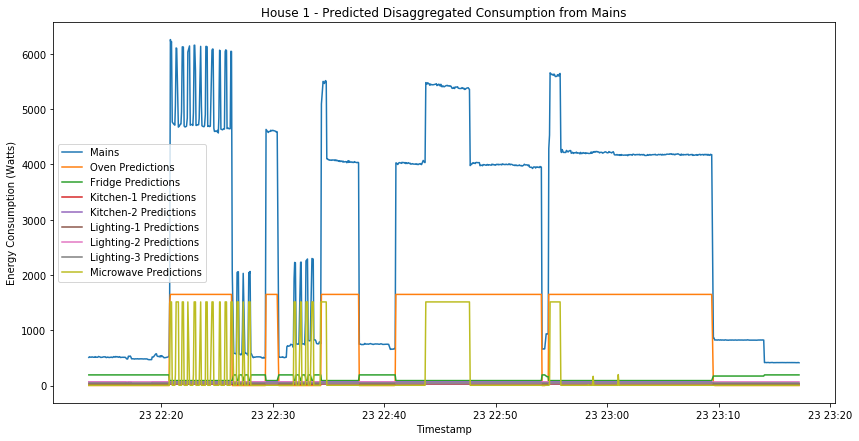

In [101]:
#House 1


train_size = (80 *len(df[1]))/100
mains_values = df[1]['mains_1'][train_size:]+df[1]['mains_2'][train_size:]
oven_pred_values = result[1]['RandomForest']['oven_3'][0]
fridge_pred_values = result[1]['RandomForest']['refrigerator_5'][0]
kitchen7_pred_values = result[1]['RandomForest']['kitchen_outlets_7'][0]
kitchen8_pred_values = result[1]['RandomForest']['kitchen_outlets_8'][0]
lighting9_pred_values = result[1]['RandomForest']['lighting_9'][0]
lighting17_pred_values = result[1]['RandomForest']['lighting_17'][0]
lighting18_pred_values = result[1]['RandomForest']['lighting_18'][0]
microwave11_pred_values = result[1]['RandomForest']['microwave_11'][0]
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 14
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size

timeline = df[1]['TimeStamp'][train_size+62400:train_size+63400]
plt.plot(timeline, mains_values[62400:63400], label="Mains")
plt.plot(timeline, oven_pred_values[62400:63400], label="Oven Predictions")
plt.plot(timeline, fridge_pred_values[62400:63400], label="Fridge Predictions")
plt.plot(timeline, kitchen7_pred_values[62400:63400], label="Kitchen-1 Predictions")
plt.plot(timeline, kitchen8_pred_values[62400:63400], label="Kitchen-2 Predictions")
plt.plot(timeline, lighting9_pred_values[62400:63400], label="Lighting-1 Predictions")
plt.plot(timeline, lighting17_pred_values[62400:63400], label="Lighting-2 Predictions")
plt.plot(timeline, lighting18_pred_values[62400:63400], label="Lighting-3 Predictions")
plt.plot(timeline, microwave11_pred_values[62400:63400], label="Microwave Predictions")

plt.title('House 1 - Predicted Disaggregated Consumption from Mains')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption (Watts)')
plt.legend()
plt.show()

63368


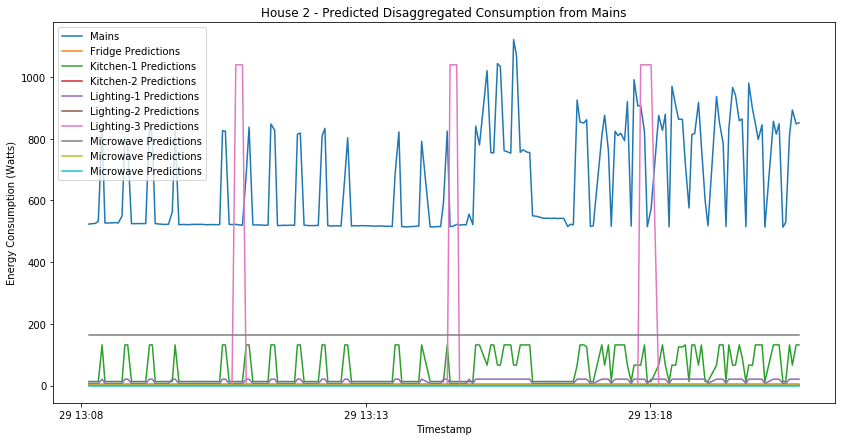

In [102]:
#House 2

train_size = (80 *len(df[2]))/100
mains_values = df[2]['mains_1'][train_size:]+df[2]['mains_2'][train_size:]
kitchen3_pred_values = result[2]['RandomForest']['kitchen_outlets_3'][0]
lighting_pred_values = result[2]['RandomForest']['lighting_4'][0]
stove_pred_values = result[2]['RandomForest']['stove_5'][0]
microwave_pred_values = result[2]['RandomForest']['microwave_6'][0]
washer_pred_values = result[2]['RandomForest']['washer_dryer_7'][0]
kitchen8_pred_values = result[2]['RandomForest']['kitchen_outlets_8'][0]
fridge_pred_values = result[2]['RandomForest']['refrigerator_9'][0]
dish_pred_values = result[2]['RandomForest']['dishwaser_10'][0]
disposal_pred_values = result[2]['RandomForest']['disposal_11'][0]

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 14
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size

print(len(mains_values))
start = 2200
end = 2400

timeline = df[2]['TimeStamp'][train_size + start: train_size + end]
plt.plot(timeline, mains_values[start:end], label="Mains")
plt.plot(timeline, kitchen3_pred_values[start:end], label="Fridge Predictions")
plt.plot(timeline, lighting_pred_values[start:end], label="Kitchen-1 Predictions")
plt.plot(timeline, stove_pred_values[start:end], label="Kitchen-2 Predictions")
plt.plot(timeline, microwave_pred_values[start:end], label="Lighting-1 Predictions")
plt.plot(timeline, washer_pred_values[start:end], label="Lighting-2 Predictions")
plt.plot(timeline, kitchen8_pred_values[start:end], label="Lighting-3 Predictions")
plt.plot(timeline, fridge_pred_values[start:end], label="Microwave Predictions")
plt.plot(timeline, dish_pred_values[start:end], label="Microwave Predictions")
plt.plot(timeline, disposal_pred_values[start:end], label="Microwave Predictions")

plt.title('House 2 - Predicted Disaggregated Consumption from Mains')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption (Watts)')
plt.legend()
plt.show()

In [105]:
display(mapping[3])

{1: 'mains_1',
 2: 'mains_2',
 3: 'outlets_unknown_3',
 4: 'outlets_unknown_4',
 5: 'lighting_5',
 6: 'electronics_6',
 7: 'refrigerator_7',
 8: 'disposal_8',
 9: 'dishwaser_9',
 10: 'furance_10',
 11: 'lighting_11',
 12: 'outlets_unknown_12',
 13: 'washer_dryer_13',
 14: 'washer_dryer_14',
 15: 'lighting_15',
 16: 'microwave_16',
 17: 'lighting_17',
 18: 'smoke_alarms_18',
 19: 'lighting_19',
 20: 'bathroom_gfi_20',
 21: 'kitchen_outlets_21',
 22: 'kitchen_outlets_22'}

75230


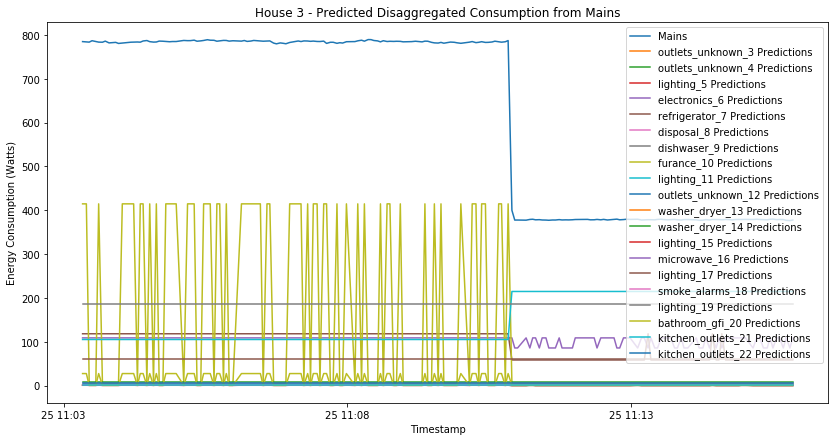

In [116]:
#House 3

train_size = (80 *len(df[3]))/100
mains_values = df[3]['mains_1'][train_size:]+df[3]['mains_2'][train_size:]
outlets_unknown_3 = result[3]['RandomForest']['outlets_unknown_3'][0]
outlets_unknown_4 = result[3]['RandomForest']['outlets_unknown_4'][0]
lighting_5 = result[3]['RandomForest']['lighting_5'][0]
electronics_6 = result[3]['RandomForest']['electronics_6'][0]
refrigerator_7 = result[3]['RandomForest']['refrigerator_7'][0]
disposal_8 = result[3]['RandomForest']['disposal_8'][0]
dishwaser_9 = result[3]['RandomForest']['dishwaser_9'][0]
furance_10 = result[3]['RandomForest']['furance_10'][0]
lighting_11 = result[3]['RandomForest']['lighting_11'][0]
outlets_unknown_12 = result[3]['RandomForest']['outlets_unknown_12'][0]
washer_dryer_13 = result[3]['RandomForest']['washer_dryer_13'][0]
washer_dryer_14 = result[3]['RandomForest']['washer_dryer_14'][0]
lighting_15 = result[3]['RandomForest']['lighting_15'][0]
microwave_16 = result[3]['RandomForest']['microwave_16'][0]
lighting_17 = result[3]['RandomForest']['lighting_17'][0]
smoke_alarms_18 = result[3]['RandomForest']['smoke_alarms_18'][0]
lighting_19 = result[3]['RandomForest']['lighting_19'][0]
bathroom_gfi_20 = result[3]['RandomForest']['bathroom_gfi_20'][0]
kitchen_outlets_21 = result[3]['RandomForest']['kitchen_outlets_21'][0]
kitchen_outlets_22 = result[3]['RandomForest']['kitchen_outlets_22'][0]

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 14
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size

print(len(mains_values))
start = 16800
end = 17000

timeline = df[3]['TimeStamp'][train_size + start: train_size + end]
plt.plot(timeline, mains_values[start:end], label="Mains")
plt.plot(timeline, outlets_unknown_3[start:end], label="outlets_unknown_3 Predictions")
plt.plot(timeline, outlets_unknown_4[start:end], label="outlets_unknown_4 Predictions")
plt.plot(timeline, lighting_5[start:end], label="lighting_5 Predictions")
plt.plot(timeline, electronics_6[start:end], label="electronics_6 Predictions")
plt.plot(timeline, refrigerator_7[start:end], label="refrigerator_7 Predictions")
plt.plot(timeline, disposal_8[start:end], label="disposal_8 Predictions")
plt.plot(timeline, dishwaser_9[start:end], label="dishwaser_9 Predictions")
plt.plot(timeline, furance_10[start:end], label="furance_10 Predictions")
plt.plot(timeline, lighting_11[start:end], label="lighting_11 Predictions")
plt.plot(timeline, outlets_unknown_12[start:end], label="outlets_unknown_12 Predictions")
plt.plot(timeline, washer_dryer_13[start:end], label="washer_dryer_13 Predictions")
plt.plot(timeline, washer_dryer_14[start:end], label="washer_dryer_14 Predictions")
plt.plot(timeline, lighting_15[start:end], label="lighting_15 Predictions")
plt.plot(timeline, microwave_16[start:end], label="microwave_16 Predictions")
plt.plot(timeline, lighting_17[start:end], label="lighting_17 Predictions")
plt.plot(timeline, smoke_alarms_18[start:end], label="smoke_alarms_18 Predictions")
plt.plot(timeline, lighting_19[start:end], label="lighting_19 Predictions")
plt.plot(timeline, bathroom_gfi_20[start:end], label="bathroom_gfi_20 Predictions")
plt.plot(timeline, kitchen_outlets_21[start:end], label="kitchen_outlets_21 Predictions")
plt.plot(timeline, kitchen_outlets_22[start:end], label="kitchen_outlets_22 Predictions")


plt.title('House 3 - Predicted Disaggregated Consumption from Mains')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption (Watts)')
plt.legend()
plt.show()

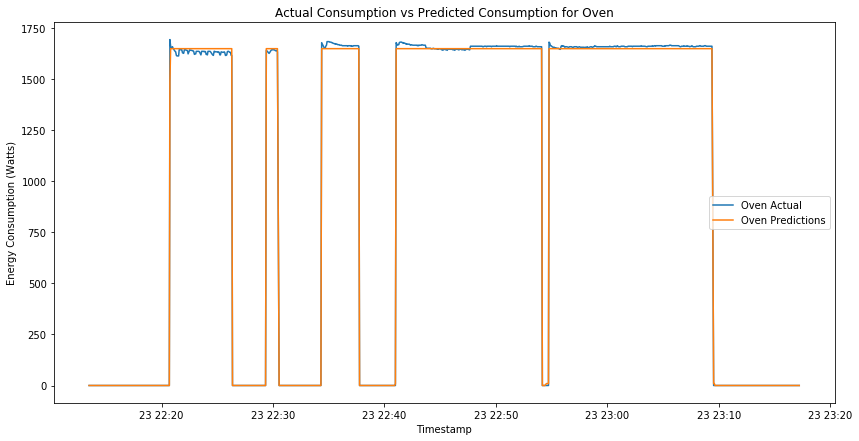

In [13]:
oven_actual_values = df[1]['oven_3'][train_size:]
oven_pred_values = result['RandomForest']['oven_3'][0]

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 14
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size
timeline = df[1]['TimeStamp'][train_size+62400:train_size+63400]
plt.plot(timeline, oven_actual_values[62400:63400], label="Oven Actual")
plt.plot(timeline, oven_pred_values[62400:63400], label="Oven Predictions")
plt.title('Actual Consumption vs Predicted Consumption for Oven')
plt.xlabel('Timestamp')
plt.ylabel('Energy Consumption (Watts)')
plt.legend()
plt.show()

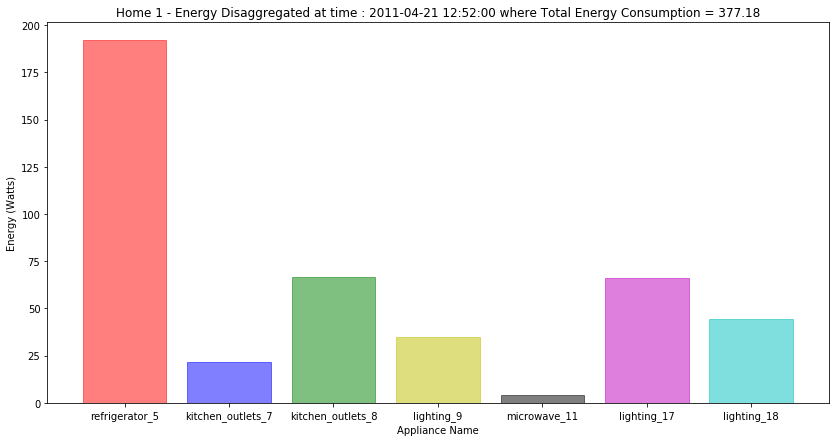

In [132]:
#House 1 

objects_1 = []
performance = []
timestamp = 62800
mains_consumption = str(df[1]['mains_1'][timestamp] + df[1]['mains_2'][timestamp])
for key , target in mapping[1].iteritems():
    if target != 'mains_1' and target != 'mains_2' and result[1]['RandomForest'][target][0][timestamp] > 2:
        objects_1.append(target)
        performance.append(result[1]['RandomForest'][target][0][timestamp])

y_pos = np.arange(len(objects_1))

barlist = plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects_1)
plt.ylabel('Energy (Watts)')
plt.xlabel('Appliance Name')
plt.title('Home 1 - Energy Disaggregated at time : ' + str(df[1]['TimeStamp'][timestamp]) + ' where Total Energy Consumption = 377.18')
barlist[0].set_color('r')
barlist[1].set_color('b')
barlist[2].set_color('g')
barlist[3].set_color('y')
barlist[4].set_color('k')
barlist[5].set_color('m')
barlist[6].set_color('c')
plt.show()

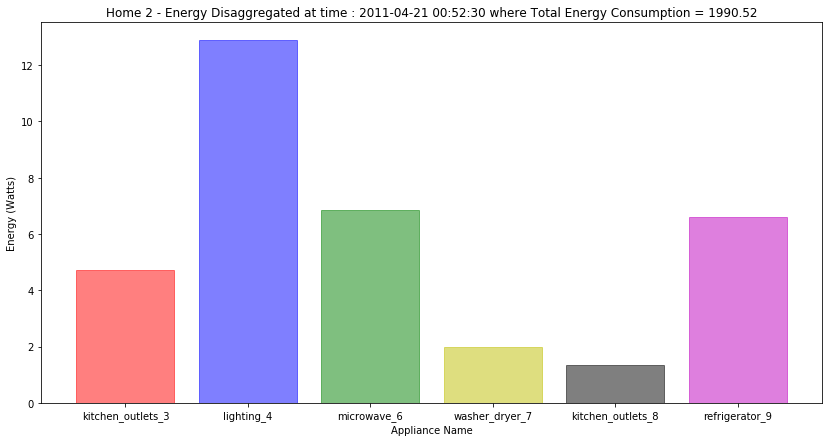

In [133]:
#House 2

objects_2 = []
performance = []
timestamp = 62800
mains_consumption = str(df[2]['mains_1'][timestamp] + df[2]['mains_2'][timestamp])
for key , target in mapping[2].iteritems():
    if target != 'mains_1' and target != 'mains_2' and result[2]['RandomForest'][target][0][timestamp] > 1:
        objects_2.append(target)
        performance.append(result[2]['RandomForest'][target][0][timestamp])

y_pos = np.arange(len(objects_2))
barlist = plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects_2)
plt.ylabel('Energy (Watts)')
plt.xlabel('Appliance Name')
plt.title('Home 2 - Energy Disaggregated at time : ' + str(df[2]['TimeStamp'][timestamp]) + ' where Total Energy Consumption = 1990.52')
barlist[0].set_color('r')
barlist[1].set_color('b')
barlist[2].set_color('g')
barlist[3].set_color('y')
barlist[4].set_color('k')
barlist[5].set_color('m')
plt.show()

140.58


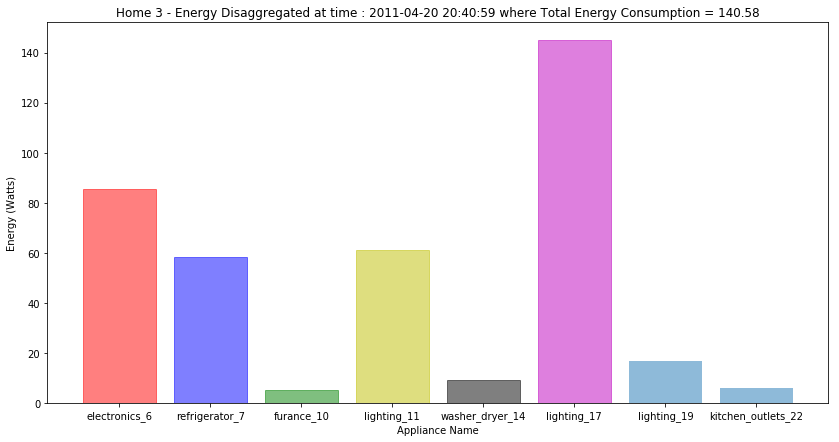

In [134]:
#House 3

objects_3 = []
performance = []
timestamp = 62800
mains_consumption = str(df[3]['mains_1'][timestamp] + df[3]['mains_2'][timestamp])
print(mains_consumption)
for key , target in mapping[3].iteritems():
    if target != 'mains_1' and target != 'mains_2' and result[3]['RandomForest'][target][0][timestamp] > 5:
        objects_3.append(target)
        performance.append(result[3]['RandomForest'][target][0][timestamp])

y_pos = np.arange(len(objects_3))
barlist = plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects_3)
plt.ylabel('Energy (Watts)')
plt.xlabel('Appliance Name')
plt.title('Home 3 - Energy Disaggregated at time : ' + str(df[3]['TimeStamp'][timestamp]) + ' where Total Energy Consumption = 140.58')
barlist[0].set_color('r')
barlist[1].set_color('b')
barlist[2].set_color('g')
barlist[3].set_color('y')
barlist[4].set_color('k')
barlist[5].set_color('m')
plt.show()

In [139]:
#House 1

output = {}
output[1] = {}
algorithms = ['RandomForest' , 'Linear' , 'Ridge' , 'Lasso', 'Baysian']
updated_objects_1 = objects_1
updated_objects_1.append('oven_3')
updated_objects_1.append('oven_4')
for app in updated_objects_1 :
    output[1][app] = {}
    for algo in algorithms:
        output[1][app][algo] = round(result[1][algo][app][1],5)
display(output[1])

{'kitchen_outlets_7': {'Baysian': 1.23761,
  'Lasso': 1.23546,
  'Linear': 1.2399,
  'RandomForest': 1.22596,
  'Ridge': 1.2399},
 'kitchen_outlets_8': {'Baysian': 7.36458,
  'Lasso': 7.39798,
  'Linear': 7.36346,
  'RandomForest': 4.70985,
  'Ridge': 7.36345},
 'lighting_17': {'Baysian': 12.07707,
  'Lasso': 12.16561,
  'Linear': 12.07517,
  'RandomForest': 3.36966,
  'Ridge': 12.07516},
 'lighting_18': {'Baysian': 10.20229,
  'Lasso': 10.16571,
  'Linear': 10.20155,
  'RandomForest': 7.59965,
  'Ridge': 10.20151},
 'lighting_9': {'Baysian': 22.16393,
  'Lasso': 22.27476,
  'Linear': 22.14884,
  'RandomForest': 26.5362,
  'Ridge': 22.14877},
 'microwave_11': {'Baysian': 5.59662,
  'Lasso': 5.61238,
  'Linear': 5.5963,
  'RandomForest': 1.17825,
  'Ridge': 5.59643},
 'oven_3': {'Baysian': 5.0567,
  'Lasso': 5.05589,
  'Linear': 5.05737,
  'RandomForest': 0.37884,
  'Ridge': 5.05737},
 'oven_4': {'Baysian': 7.37607,
  'Lasso': 7.32351,
  'Linear': 7.3776,
  'RandomForest': 2.75477,
  'R

In [143]:
#House 2

output[2] = {}
algorithms = ['RandomForest' , 'Linear' , 'Ridge' , 'Lasso', 'Baysian']
updated_objects_2 = objects_2
for app in updated_objects_2 :
    output[2][app] = {}
    for algo in algorithms:
        output[2][app][algo] = round(result[2][algo][app][1],5)
display(output[2])

{'kitchen_outlets_3': {'Baysian': 7.66246,
  'Lasso': 7.74284,
  'Linear': 7.64946,
  'RandomForest': 5.5835,
  'Ridge': 7.64947},
 'kitchen_outlets_8': {'Baysian': 22.91681,
  'Lasso': 22.85459,
  'Linear': 22.93785,
  'RandomForest': 2.35762,
  'Ridge': 22.93782},
 'lighting_4': {'Baysian': 23.71168,
  'Lasso': 23.61582,
  'Linear': 23.71576,
  'RandomForest': 16.58174,
  'Ridge': 23.71573},
 'microwave_6': {'Baysian': 69.91727,
  'Lasso': 69.71686,
  'Linear': 69.92934,
  'RandomForest': 7.3302,
  'Ridge': 69.92926},
 'refrigerator_9': {'Baysian': 69.59285,
  'Lasso': 69.49174,
  'Linear': 69.59858,
  'RandomForest': 13.11897,
  'Ridge': 69.59857},
 'washer_dryer_7': {'Baysian': 0.96939,
  'Lasso': 0.86492,
  'Linear': 0.96938,
  'RandomForest': 0.64181,
  'Ridge': 0.96938}}

In [144]:
#House 3

output[3] = {}
algorithms = ['RandomForest' , 'Linear' , 'Ridge' , 'Lasso', 'Baysian']
updated_objects_3 = objects_3
for app in updated_objects_3 :
    output[3][app] = {}
    for algo in algorithms:
        output[3][app][algo] = round(result[3][algo][app][1],5)
display(output[3])

{'electronics_6': {'Baysian': 37.20833,
  'Lasso': 37.26632,
  'Linear': 37.20816,
  'RandomForest': 29.27969,
  'Ridge': 37.20816},
 'furance_10': {'Baysian': 12.03134,
  'Lasso': 11.85644,
  'Linear': 12.05473,
  'RandomForest': 4.3699,
  'Ridge': 12.05467},
 'kitchen_outlets_22': {'Baysian': 20.49944,
  'Lasso': 20.40938,
  'Linear': 20.50987,
  'RandomForest': 10.43238,
  'Ridge': 20.50979},
 'lighting_11': {'Baysian': 18.67276,
  'Lasso': 18.55313,
  'Linear': 18.67495,
  'RandomForest': 26.75135,
  'Ridge': 18.67493},
 'lighting_17': {'Baysian': 17.66323,
  'Lasso': 17.50273,
  'Linear': 17.66487,
  'RandomForest': 15.96966,
  'Ridge': 17.66481},
 'lighting_19': {'Baysian': 11.31605,
  'Lasso': 11.13911,
  'Linear': 11.31768,
  'RandomForest': 6.51774,
  'Ridge': 11.31761},
 'refrigerator_7': {'Baysian': 21.48323,
  'Lasso': 21.47128,
  'Linear': 21.48291,
  'RandomForest': 24.92794,
  'Ridge': 21.48291},
 'washer_dryer_14': {'Baysian': 12.49049,
  'Lasso': 12.29422,
  'Linear': 

In [145]:
#final accuracy

final = {}
for j in range(1,4):
    final[j] = {}
    num = 0
    den = 0
    train_size = (80 *len(df[j]))/100
    for algo in algorithms:
        for key , target in mapping[j].iteritems():
            actual_values = df[j][target][train_size:]
            pred_values = result[j][algo][target][0]
            for i in range(0, len(actual_values)):
                if target != 'mains_1' and target != 'mains_2':
                    num += abs(pred_values[i] - actual_values[train_size+i])
                else:
                    den += actual_values[train_size+i]
        correctness = 1- (num / (2*den))
        final[j][algo] = correctness

print(final)



{1: {'RandomForest': 0.9029965443579259, 'Ridge': 0.8292323213537272, 'Linear': 0.8476734998636986, 'Baysian': 0.8144889098344635, 'Lasso': 0.8200311907105357}, 2: {'RandomForest': 0.9384286146783146, 'Ridge': 0.7878657661112249, 'Linear': 0.8255064244210202, 'Baysian': 0.7580236360059623, 'Lasso': 0.7693485760022098}, 3: {'RandomForest': 0.5845160692965453, 'Ridge': 0.3156431385417543, 'Linear': 0.3828605648878587, 'Baysian': 0.2629296637300801, 'Lasso': 0.2833025417517864}}
